# 4.0 - solution

In this notebook I will create a model myself.

Although graph neural networks (GNN) are considered best suited for the recommender systems in general, I will try to implement a collaborative denoising autoencoder (CDAE) model. I referenced this [website](https://jameskle.com/writes/rec-sys-part-6) for the inspiration.

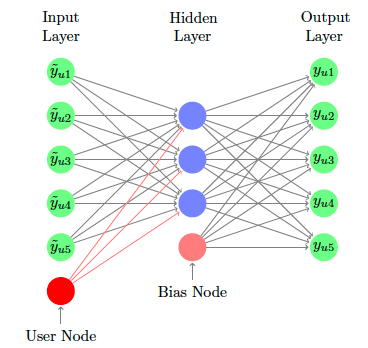

One of the obvious benefits of using simplier model would be its speed of training.


In [1]:
import sys
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

sys.path.append("../")
torch.manual_seed(69)

from benchmark.train import TrainParameters  # noqa: E402
from benchmark.metrics import metrics as compute_metrics  # noqa: E402

In [2]:
# load dataframes
train_df = pd.read_csv("../data/interim/train.csv")
test_df = pd.read_csv("../data/interim/test.csv")

In [3]:
class CustomDataset(Dataset):
    def __init__(self, df, num_users, num_items):
        i = torch.stack(
            (
                torch.LongTensor(df["user_id_idx"].values),
                torch.LongTensor(df["item_id_idx"].values),
            )
        )

        # create a sparse tensor of shape (users, items) with ones at the indices
        # of the user-item pairs
        self.matrix = torch.sparse_coo_tensor(
            indices=i,
            values=torch.ones(len(df)),
            size=(num_users, num_items),
        ).to_dense()

        self.num_users = num_users
        self.num_items = num_items

    def __len__(self):
        return len(self.matrix)

    def __getitem__(self, idx):
        return idx, self.matrix[idx]

In [4]:
class AutoRec(nn.Module):
    def __init__(self, num_users, num_items, latent_dim=32):
        super(AutoRec, self).__init__()

        self.user_embedding = nn.Embedding(num_users, latent_dim)

        self.encoder = nn.Linear(num_items, latent_dim)
        self.decoder = nn.Linear(latent_dim, num_items)

    def forward(self, user, matrix):
        user_embedding = self.user_embedding(user)
        encoded = self.encoder(matrix)

        encoded = nn.functional.sigmoid(encoded + user_embedding)

        decoded = self.decoder(encoded)
        return decoded

In [5]:
PARAMETERS = TrainParameters(
    EPOCHS=10,
    BATCH_SIZE=32,
    LR=0,  # not used here
    DECAY=0,  # not used here
    K=10,
)

In [6]:
num_users = train_df.user_id_idx.nunique()
num_items = train_df.item_id_idx.nunique()

# Creating the model
model = AutoRec(num_users, num_items)

# Creating dataset and data loader
train_dataset = CustomDataset(train_df, num_users, num_items)
train_dataloader = DataLoader(
    train_dataset, batch_size=PARAMETERS.BATCH_SIZE, shuffle=True
)

In [7]:
def validate():
    with torch.no_grad():
        preds = np.zeros_like(validation_dataloader.dataset.matrix)

        for indices, input_mat in validation_dataloader:
            input_mat = input_mat.float()
            batch_pred = torch.sigmoid(model.forward(indices, input_mat))
            batch_pred = batch_pred.masked_fill(input_mat.bool(), float("-inf"))

            indices = indices.detach().cpu().numpy()
            preds[indices] = batch_pred.detach().cpu().numpy()

    preds = torch.from_numpy(preds)
    return compute_metrics(test_df, PARAMETERS.K, preds)

In [8]:
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters())

# Create a validation dataset and data loader
validation_dataset = CustomDataset(test_df, num_users, num_items)
validation_dataloader = DataLoader(validation_dataset, batch_size=64, shuffle=False)

losses = []

# Training loop with evaluation step
for epoch in range(PARAMETERS.EPOCHS):
    running_train_loss = 0.0
    running_val_loss = 0.0

    # Training
    model.train()

    for idx, mat in train_dataloader:
        mat = mat.float()

        optimizer.zero_grad()
        outputs = model.forward(idx, mat)
        loss = criterion(outputs, mat)
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item()
    train_loss = running_train_loss / len(train_dataloader)

    # Validation
    model.eval()
    with torch.no_grad():
        losses.append(validate())
        for idx, mat in validation_dataloader:
            val_outputs = model(idx, mat)
            val_loss = criterion(val_outputs, mat)
            running_val_loss += val_loss.item()
        val_loss = running_val_loss / len(validation_dataloader)

    print(
        f"Epoch [{epoch + 1}/{PARAMETERS.EPOCHS}], Train Loss: {train_loss}, Val metrics: {val_loss}"
    )

Epoch [1/10], Train Loss: 0.6061491181453069, Val metrics: 0.4842914938926697
Epoch [2/10], Train Loss: 0.37783602277437844, Val metrics: 0.3027107775211334
Epoch [3/10], Train Loss: 0.2559410308798154, Val metrics: 0.21782084306081137
Epoch [4/10], Train Loss: 0.21137525389591852, Val metrics: 0.17853407959143322
Epoch [5/10], Train Loss: 0.19314916630585988, Val metrics: 0.15825235744317373
Epoch [6/10], Train Loss: 0.183939066529274, Val metrics: 0.14505802989006042
Epoch [7/10], Train Loss: 0.17886505325635274, Val metrics: 0.13683925966421764
Epoch [8/10], Train Loss: 0.17660557826360065, Val metrics: 0.1310551623503367
Epoch [9/10], Train Loss: 0.17338461726903914, Val metrics: 0.12670093725124995
Epoch [10/10], Train Loss: 0.1712718759973844, Val metrics: 0.12314505279064178


In [9]:
# save model
torch.save(model.state_dict(), "../models/autorec.pt")

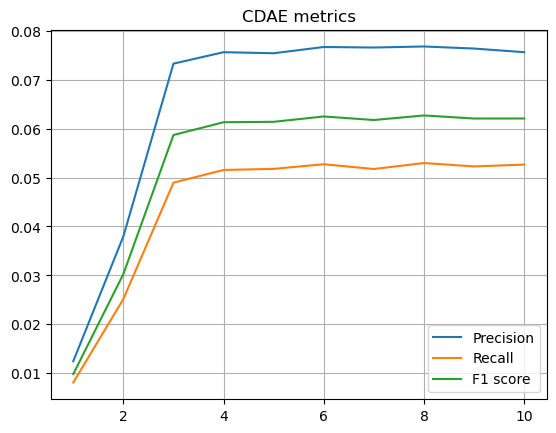

In [10]:
losses = np.array(losses)

epoch_list = [(i + 1) for i in range(PARAMETERS.EPOCHS)]
plt.plot(epoch_list, losses[:, 0], label="Precision")
plt.plot(epoch_list, losses[:, 1], label="Recall")
plt.plot(epoch_list, losses[:, 2], label="F1 score")
plt.legend()
plt.grid()

plt.title("CDAE metrics")

# save figure
plt.savefig("../reports/figures/cdae_metrics.png")

# Conclusion:

As we can see, the model I have proposed does not beat the baseline. However, it is ridiculously simplier and reaches its peak performance with 3 epochs only.

I believe it is a satisfactory result for a auto-encoder model which does not consider graph structure at all.

As I am forced by the structure of project to have `evaluate.py` file to get metrics, I will copy most of this notebook into the script.
